In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import mne
from mne import io
from mne import read_epochs

In [2]:
url = './data/'

print("\n========= epoch_1 ==========")

# epoch_1
file_name_1 = 'g1dual1_epo.fif' # eg. 'g1dual1_epo.fif'
epoch_1 = read_epochs(url + file_name_1)
print("\n========= epoch_2 ==========")

# epoch_2
file_name_2 = 'g1solo1_epo.fif' # eg. 'g1dual2_epo.fif'
epoch_2 = read_epochs(url + file_name_2)


========= epoch_1 ==========
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated

========= epoch_2 ==========
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated


In [3]:
X_1 = epoch_1.get_data()
y_1 = np.array(epoch_1.events[:, -1], dtype = 'float32')

print(X_1.shape)
print(y_1.shape)
# print(y)

(636, 32, 410)
(636,)


In [4]:
X_2 = epoch_2.get_data()
y_2 = np.array(epoch_2.events[:, -1], dtype = 'float32')

print(X_2.shape)
print(y_2.shape)
# print(y)

(240, 32, 410)
(240,)


In [5]:
# X = np.concatenate((X_1, X_2), axis=0)
# y = np.concatenate((y_1, y_2), axis=0)
# print('X shape', X.shape)
# y = y-1
# print('Y shape', y.shape)

In [6]:
X_1 = X_1.reshape(X_1.shape[0], 1, X_1.shape[1], X_1.shape[2])
X_2 = X_2.reshape(X_2.shape[0], 1, X_2.shape[1], X_2.shape[2])

print(X_1.shape)
print(X_2.shape)

(636, 1, 32, 410)
(240, 1, 32, 410)


In [7]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [9]:
X_train = torch.Tensor(X_1)
y_train = torch.Tensor(y_1)
y_train = y_train-1
y_train = y_train.unsqueeze(1)

X_test = torch.Tensor(X_2)
y_test = torch.Tensor(y_2)
y_test = y_test-1
y_test = y_test.unsqueeze(1)

print(X_train.size())
print(y_train.size())


print(X_test.size())
print(y_test.size())

torch.Size([636, 1, 32, 410])
torch.Size([636, 1])
torch.Size([240, 1, 32, 410])
torch.Size([240, 1])


In [10]:
train_ds = TensorDataset(X_train, y_train)
valid_ds = TensorDataset(X_test, y_test)

BATCH_SIZE= 64

train_iterator = torch.utils.data.DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
valid_iterator = torch.utils.data.DataLoader(dataset=valid_ds, batch_size=BATCH_SIZE, shuffle=False)

In [11]:
class CNN(nn.Module):
    def __init__(self, input_x, input_dim, hidden_dims, output_dim, dropout):
        super(CNN, self).__init__()
        self.seq_len = input_x[-1]
        self.hidden_dims = hidden_dims
        
        # layer 1 (BatchNorm)
        self.layer1 = nn.BatchNorm2d(input_dim)     
        
        # layer 2 (Conv2d, tanh)
        self.layer2 = nn.Sequential(nn.Conv2d(input_dim, self.hidden_dims[1], kernel_size = (32, self.hidden_dims[0]), 
                                        stride = 1), nn.Tanh())     
        
        # layer 3 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer3_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2],kernel_size = (1, 5), 
                                        stride = (1, 5)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 10), 
                                        stride = (1, 10)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        self.layer3_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[1], self.hidden_dims[2], kernel_size = (1, 15), 
                                        stride = (1, 15)), nn.BatchNorm2d(self.hidden_dims[2]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 4  (concat, dropout, tanh)
        
        # layer 5 (Conv2d + Conv2d + Conv2d, BatchNorm, tanh, dropout)
        self.layer5_1 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 2), 
                                        stride = (1, 2)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_2 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 4), 
                                        stride = (1, 4)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout)) 
        self.layer5_3 = nn.Sequential(nn.Conv2d(self.hidden_dims[2], self.hidden_dims[3], kernel_size = (1, 11), 
                                        stride = (1, 11)), nn.BatchNorm2d(self.hidden_dims[3]), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 6 (concat, dropout, tanh)
        
        # layer 7 (Maxpool, tanh, dropout)
        self.layer7 = nn.Sequential(nn.MaxPool2d(kernel_size = (1, 2), stride = (1, 2)), nn.Tanh(), nn.Dropout2d(dropout))  
        
        # layer 8 (Flatten, tanh, dropout)
        self.layer8 = nn.Sequential(nn.Flatten(), nn.Linear(self.hidden_dims[3] * 62, 128), nn.Tanh(), nn.Dropout2d(dropout))
        
        # layer 9 (Linear, Sigmoid)
        self.layer9 = nn.Sequential(nn.Linear(128, output_dim), nn.Sigmoid())
        
        self.dropout = nn.Sequential(nn.Dropout2d(dropout), nn.Tanh())
    
    def forward(self, x):
        
        out = self.layer1(x)
        out = self.layer2(out)
        out_3_1 = self.layer3_1(out)
        out_3_2 = self.layer3_2(out)
        out_3_3 = self.layer3_3(out)
        out = torch.cat((out_3_1, out_3_2, out_3_3),dim = 3)
        out = self.dropout(out)
        out_5_1 = self.layer5_1(out)
        out_5_2 = self.layer5_2(out)
        out_5_3 = self.layer5_3(out)
        out = torch.cat((out_5_1, out_5_2, out_5_3),dim = 3)
        out = self.dropout(out)
        out = self.layer7(out)
        out = self.layer8(out)
        out = self.layer9(out)
        
        return out

In [12]:
input_x = X_train.size()
input_dim = 1
output_dim = 1
hidden_dims = [1, 128, 64, 32]
learning_rate = 0.0001
num_epochs = 50
dropout = 0.35

In [13]:
model = CNN(input_x, input_dim, hidden_dims, output_dim, dropout).to(device)

In [14]:
num_parameters = sum(p.numel() for p in model.parameters())
print("Total number of parameters in CNN Conv2d model is {}".format(num_parameters))

Total number of parameters in CNN Conv2d model is 539875


In [15]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.RNN):
        for name, param in m.named_parameters():
            if 'bias' in name:
                nn.init.zeros_(param)
            elif 'weight' in name:
                nn.init.orthogonal_(param)
                
model.apply(initialize_weights)

CNN(
  (layer1): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Sequential(
    (0): Conv2d(1, 128, kernel_size=(32, 1), stride=(1, 1))
    (1): Tanh()
  )
  (layer3_1): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 5), stride=(1, 5))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3_2): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 10), stride=(1, 10))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer3_3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(1, 15), stride=(1, 15))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): Dropout2d(p=0.35, inplace=False)
  )
  (layer5_1): Sequential(
    (0): Conv2d(64, 32, kernel_size=(1, 2), stride=(1, 2))


In [16]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [17]:
# y_pred_list = []
# y_true_list = []

def train(model, iterator, optimizer, criterion):
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    
    for batch, labels in iterator:
        
        #Move tensors to the configured device
        batch = batch.to(device)
        labels = labels.to(device)
#         print("labels shape: ", labels.size())
        #Forward pass
        outputs = model(batch.float())
#         print("outputs: ", outputs)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
                
        #check accuracy
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()
        
        
        
        predictions = model(batch.float())
        predicted = predictions.round()
#         print("predicted: ", predicted)
        total += labels.size(0)  #keep track of total
        correct += (predicted == labels).sum().item()
        acc = 100 * (correct / total)               
        epoch_loss += loss.item()
        epoch_acc = acc
        
    return epoch_loss / len(iterator), epoch_acc, predicted

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for i, (batch, labels) in enumerate(iterator):
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)
#             y_target = labels.cpu().detach().numpy().squeeze()
#             for i in range(labels.size(0)):
#                 y_true_list.append(y_target[i])
            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
            
            print("test predicted",predicted.T)

#             predicted = predicted.unsqueeze(1)
#             y_pred = predicted.cpu().detach().numpy().squeeze()
#             for i in range(labels.size(0)):
#                 y_pred_list.append(y_pred[i])

            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [18]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [19]:
N_EPOCHS = 100

best_valid_loss = float('inf')

train_losses = []
valid_losses = []

train_accs = []
valid_accs = []

train_predicted_labels = []
valid_predicted_labels = []

train_true_labels = []
valid_true_labels = []

# for i, model in enumerate(models):
#     print(f"Training {type(model).__name__}")
    
#     start_time = time.time()

for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss, train_acc, predicted_train = train(model, train_iterator, optimizer, criterion)
    valid_loss, valid_acc, predicted_eval = evaluate(model, valid_iterator, criterion)

    train_losses.append(train_loss); train_accs.append(train_acc); train_predicted_labels.append(predicted_train)
    valid_losses.append(valid_loss); valid_accs.append(valid_acc); valid_predicted_labels.append(predicted_eval)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if (epoch+1) % 1 == 0:
        print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc:.2f}%')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc:.2f}%')

#         print(predicted_train)
#         print(predicted_eval)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        
    if train_acc > 95 and valid_acc > 93 and valid_loss <= 0.20:
        N_EPOCHS = epoch
        break
#         print("Model:{} saved.".format(type(model).__name__))
#         torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
#         best_model_index = i

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       device='cuda:0')
test predicted tensor([[0., 

test predicted tensor([[0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 1., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 1., 0.]], device='cuda:0')
Epoch: 07 | Epoch Time: 0m 1s
	Train Loss: 0.439 | Train Acc: 83.18%
	 Val. Loss: 0.583 |  Val. Acc: 71.63%
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0.,
         1., 1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], devi

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
Epoch: 20 | Epoch Time: 0m 0s
	Train Loss: 0.338 | Train Acc: 86.01%
	 Val. Loss: 0.308 |  Val. Acc: 88.15%
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], devi

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 0.]], device='cuda:0')
Epoch: 33 | Epoch Time: 0m 0s
	Train Loss: 0.271 | Train Acc: 88.52%
	 Val. Loss: 0.324 |  Val. Acc: 86.25%
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], devi

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 1.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
         0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 1., 0., 1., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 1., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]], device='cuda:0')
test predicted tensor([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]], device='cuda:0')
test predicted tensor(

In [20]:
# from sklearn.metrics import classification_report

# print(classification_report(y_true_list, y_pred_list))

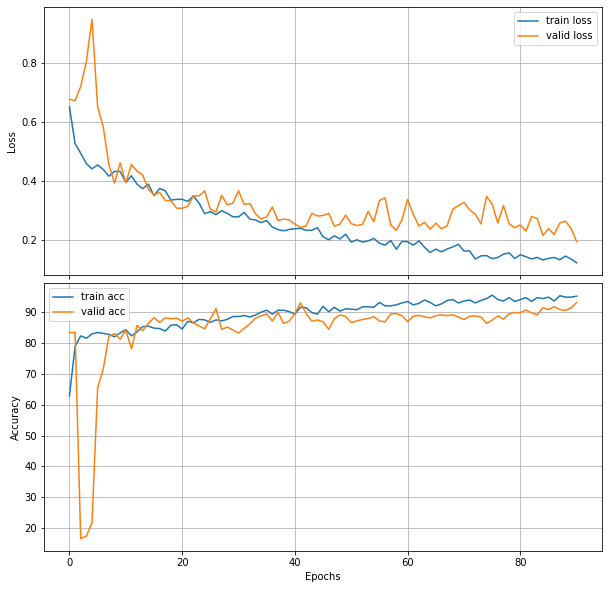

In [21]:
fig,ax = plt.subplots(2,1,sharex=True,figsize=(10,10))
ax[0].plot(np.arange(N_EPOCHS+1),train_losses,label = "train loss")
ax[0].plot(np.arange(N_EPOCHS+1),valid_losses, label = "valid loss")
ax[1].plot(np.arange(N_EPOCHS+1),train_accs,label = "train acc")
ax[1].plot(np.arange(N_EPOCHS+1),valid_accs,label = "valid acc")

plt.subplots_adjust(hspace=0.03)
ax[1].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy")
ax[0].legend()
ax[1].legend()
ax[0].grid(True)
ax[1].grid(True)
plt.show()

In [22]:
# PATH = "conv2d.pt"
# LOSS = 0.173

# torch.save({
#             'epoch': N_EPOCHS,
#             'model_state_dict': model.state_dict(),
#             'optimizer_state_dict': optimizer.state_dict(),
#             'loss': LOSS,
#             }, PATH)

In [23]:
# checkpoint = torch.load(PATH)
# model.load_state_dict(checkpoint['model_state_dict'])
# optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
# epoch = checkpoint['epoch']
# loss = checkpoint['loss']

In [24]:
y_pred_list = []
y_true_list = []

def evaluate(model, iterator, criterion):
    
    total = 0
    correct = 0
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    
    with torch.no_grad():
    
        for batch, labels in iterator:
            
            #Move tensors to the configured device
            batch = batch.to(device)
            labels = labels.to(device)
            
            y_target = labels.cpu().detach().numpy().squeeze()
            for i in range(labels.size(0)):
                y_true_list.append(y_target[i])
            predictions = model(batch.float())
            loss = criterion(predictions, labels)

#             _, predicted = torch.max(predictions.data, 1)  #returns max value, indices
            predicted = predictions.round()
            
#             if i%3 == 0:
#                 print("test predicted",predicted.T)

#             predicted = predicted.unsqueeze(1)
            y_pred = predicted.cpu().detach().numpy().squeeze()
            for i in range(labels.size(0)):
                y_pred_list.append(y_pred[i])
            
            total += labels.size(0)  #keep track of total
            correct += (predicted == labels).sum().item()  #.item() give the raw number
            acc = 100 * (correct / total)
            
            epoch_loss += loss.item()
            epoch_acc += acc
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator) , predicted

In [25]:
accuracy_list = 0
subject_no = 1
for i in range(1, 20):
    for j in range(1,3):
        print("Subject No:", subject_no)
        subject_no += 1
        print(f"g{i}dual{j}_epo.fif")
        print(f"g{i}solo{j}_epo.fif")
        test_file_1 = 'g'+str(i)+'dual'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_1 = read_epochs(url + test_file_1)
        test_file_2 = 'g'+str(i)+'solo'+str(j)+'_epo.fif' # eg. 'g1dual1_epo.fif'
        epoch_2 = read_epochs(url + test_file_2)

        X_test1 = epoch_1.get_data()
        y_test1 = np.array(epoch_1.events[:, -1], dtype = 'float32')

        X_test2 = epoch_2.get_data()
        y_test2 = np.array(epoch_2.events[:, -1], dtype = 'float32')

        X_test = np.concatenate((X_test1, X_test2), axis=0)
        y_test = np.concatenate((y_test1, y_test2), axis=0)
        X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])
        # print(X_train.shape)
        # print(y_train.shape)

        X_test = torch.Tensor(X_test)
        y_test = torch.Tensor(y_test)
        y_test = y_test-1
        y_test = y_test.unsqueeze(1)
        # print(X_val.size())
        # print(y_val.size())

        test_ds = TensorDataset(X_test, y_test)

        BATCH_SIZE= 64

        test_iterator = torch.utils.data.DataLoader(dataset=test_ds, batch_size=BATCH_SIZE, shuffle=False)

        test_losses = []
        test_accs = []
        test_predicted_labels = []
        best_test_loss = float("inf")

        # for epoch in range(N_EPOCHS):
        start_time = time.time()

        test_loss, test_acc, predicted_test_eval = evaluate(model, test_iterator, criterion)

        test_losses.append(test_loss); test_accs.append(test_acc); test_predicted_labels.append(predicted_test_eval)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        # if (epoch+1) % 5 == 0:
        # print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
        print(f'\t Test. Loss: {test_loss:.3f} |  Test. Acc: {test_acc:.2f}%')
        print("================================================")
        print("================================================")
        print("================================================")
        
        accuracy_list += test_acc
print("Total average accuracy for all 38 subjects is {}".format(accuracy_list/38))

        #         print(predicted_train)
        #         print(predicted_eval)

        # if test_loss < best_test_loss:
        #     best_test_loss = test_loss
        #         print("Model:{} saved.".format(type(model).__name__))
        #         torch.save(model.state_dict(), 'models/checkpoint.pth.tar')
#                 4best_model_index = i

Subject No: 1
g1dual1_epo.fif
g1solo1_epo.fif
Reading ./data/g1dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
240 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.096 |  Test. Acc: 98.21%
Subject No: 2
g1dual2_epo.fif
g1solo2_epo.fif
Reading ./data/g1dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
636 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g1solo

Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
216 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.507 |  Test. Acc: 83.61%
Subject No: 12
g6dual2_epo.fif
g6solo2_epo.fif
Reading ./data/g6dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
744 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g6solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correct

        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
192 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.771 |  Test. Acc: 85.24%
Subject No: 22
g11dual2_epo.fif
g11solo2_epo.fif
Reading ./data/g11dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
516 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g11solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
156 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.847 |  Test. Acc: 81.71%
Subject No: 23
g12dual1_epo.fif
g12solo1_epo.fif
Reading ./data/g12dual1_epo.fif ...
    Found the data of interest:
        t = 

	 Test. Loss: 0.682 |  Test. Acc: 86.21%
Subject No: 32
g16dual2_epo.fif
g16solo2_epo.fif
Reading ./data/g16dual2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
0 projection items activated
Reading ./data/g16solo2_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
252 matching events found
No baseline correction applied
0 projection items activated
	 Test. Loss: 0.816 |  Test. Acc: 81.93%
Subject No: 33
g17dual1_epo.fif
g17solo1_epo.fif
Reading ./data/g17dual1_epo.fif ...
    Found the data of interest:
        t =     -99.61 ...     699.22 ms
        0 CTF compensation matrices available
Not setting metadata
Not setting metadata
588 matching events found
No baseline correction applied


In [26]:
from sklearn.metrics import classification_report

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

         0.0       0.86      0.94      0.90     28530
         1.0       0.42      0.20      0.27      5706

    accuracy                           0.82     34236
   macro avg       0.64      0.57      0.59     34236
weighted avg       0.78      0.82      0.79     34236

